## Imports

In [3]:
import torch
from torch.utils.data import DataLoader

from src.utils_data import load_PeMS04_flow_data, preprocess_PeMS_data, createLoaders, TimeSeriesDataset
from src.utils_graph import compute_laplacian_with_self_loop
from src.models import TGCN, GRUModel, LSTMModel, train_model

import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Print Results

In [4]:
def result_prediction(predictions, actuals):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    import numpy as np
    
    indices_by_month = []
    EPSILON = 1e-5
    # Créer une liste vide pour stocker les données du tableau
    data = []
    y_pred = predictions[:]
    y_true = actuals[:]

    signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    if (mape > 1 or mape < 0):
        mape = "ERROR"
    smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
    maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100
    
    return [signe, mae, rmse, mape, smape, maape]

In [5]:
def highlight_rows(row, min_val, max_val):
    if row["MAAPE"] == min_val:
        color = "green"
    elif row["MAAPE"] == max_val:
        color = "red"
    else:
        color = ""
    return [f'background-color: {color}'] * len(row)

## Test Model

In [6]:
def test_model(best_model, test_loader):
    import numpy as np
    
    # Load the best model and evaluate on the test set
    best_model.double()
    best_model.eval()
    criterion = torch.nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model.to(device)

    # Evaluate the model on the test set
    test_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = (inputs).to(device)
            targets = (targets).squeeze().to(device)
            outputs = best_model(inputs).squeeze()
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            # Save the predictions and actual values for plotting later
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())
    test_loss /= len(test_loader)
    # print(f"Test Loss: {test_loss:.4f}")
    
    # Concatenate the predictions and actuals
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    return (predictions, actuals)

## Preprocessing data

In [7]:
df_PeMS, df_distance  = load_PeMS04_flow_data()
n_neighbors = 49
normalization = "center_and_reduce"
path_save_model = f"./{normalization}/nb_captor_{n_neighbors+1}"
df_PeMS, adjacency_matrix_PeMS, meanstd_dict = preprocess_PeMS_data(df_PeMS, df_distance, init_node=0, n_neighbors=n_neighbors, center_and_reduce=True)

c:\Users\gcogoni\Documents\Stage\Federated-Traffic-Flow-Forecasting\src\utils_graph.py:98: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph, nodelist=nodes_order, weight=None).toarray()


In [8]:
# Define the sliding window size and stride
_window_size = 7
_stride = 1

In [9]:
import matplotlib.pyplot as plt
def plot_losses(losses, title, label_line):
    plt.figure(figsize=(25, 9))
    plt.title(title)
    plt.plot(losses, label=label_line)
    plt.legend(fontsize=12)
    plt.show()

In [10]:
import copy
def create_multiple_model_with_one_captor(model, nb_model, name_dict, data, _windows_size, _stride):
    dict_model = {}
    for i in range(nb_model):
        #print(f"{name_dict}{i}")
        train_loader, val_loader, test_loader = createLoaders(pd.DataFrame(data.iloc[:, i]), window_size=_windows_size, stride=_stride)
        dict_model[f"{name_dict}{i}"] = {
                                "model": copy.deepcopy(model),
                                "train_loader": train_loader,
                                "val_loader": val_loader,
                                "test_loader": test_loader
        }
    return dict_model

## TGCN

In [11]:
train_loader_TGCN, val_loader_TGCN, test_loader_TGCN = createLoaders(df_PeMS, window_size=_window_size, stride=_stride)
model_TGCN = TGCN(adjacency_matrix_PeMS, hidden_dim=32, output_size=len(df_PeMS.columns))

In [12]:
import matplotlib.pyplot as plt

num_epochs_TGCN = 300
# model_path = f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl"
# _ , valid_losses, train_losses = train_model(model_TGCN, train_loader_TGCN, val_loader_TGCN, model_path=model_path, num_epochs=num_epochs_TGCN, remove=False)

# plot_losses(train_losses, "TGCN train_losses", "train_losses")
# plot_losses(valid_losses, "TGCN valid losses", "valid_losses")


## Univariate 

In [13]:
# # LSTM
# num_epochs_LSTM_univariate = 3
# models_univaritate_LSTM = {}

# # GRU
# num_epochs_GRU_univaritate = 3
# models_univaritate_GRU = {}

In [14]:
# # LSTM
# models_univaritate_LSTM = create_multiple_model_with_one_captor(LSTMModel(1,32,1), n_neighbors+1, "LSTMModel", df_PeMS, _window_size, _stride)

# for i in range(n_neighbors+1):
#     _, valid_losses, train_losses = train_model(models_univaritate_LSTM[f"LSTMModel{i}"]["model"], 
#                 models_univaritate_LSTM[f"LSTMModel{i}"]["train_loader"], 
#                 models_univaritate_LSTM[f"LSTMModel{i}"]["val_loader"], 
#                 f"{path_save_model}/epoch_{num_epochs_LSTM_univariate}/univariate_LSTM_model_{i}.pkl", num_epochs=num_epochs_LSTM_univariate, remove=False)
#     plot_losses(train_losses, f"LSTM train_losses captor {df_PeMS.columns[i]}", "train_losses")
#     plot_losses(valid_losses, f"LSTM valid_losses captor {df_PeMS.columns[i]}", "valid_losses")


# # GRU
# models_univaritate_GRU = create_multiple_model_with_one_captor(GRUModel(1, 32, 1), n_neighbors+1, "GRUModel", df_PeMS, _window_size, _stride)

# for i in range(n_neighbors+1):
#     _, valid_losses, train_losses = train_model(models_univaritate_GRU[f"GRUModel{i}"]["model"], 
#             models_univaritate_GRU[f"GRUModel{i}"]["train_loader"], 
#             models_univaritate_GRU[f"GRUModel{i}"]["val_loader"], 
#             f"{path_save_model}/epoch_{num_epochs_GRU_univaritate}/univariate_GRU_model_{i}.pkl", num_epochs=num_epochs_GRU_univaritate, remove=False)
#     plot_losses(train_losses, f"GRU train_losses captor {df_PeMS.columns[i]}", "train_losses")
#     plot_losses(valid_losses, f"GRU valid_losses captor {df_PeMS.columns[i]}", "valid_losses")

## Results Multivariate vs Univariate (TGCN VS LSTM - GRU)

In [15]:
# import matplotlib.pyplot as plt
# ######################################################################
# # TGCN
# ######################################################################
# # load best model
# model_TGCN.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl".format(input)))

# # Make predictions
# predictions_TGCN, actuals_TGCN = test_model(model_TGCN, test_loader_TGCN)


# for i in range(n_neighbors+1):
#     # Save result for each captor
#     temp = result_prediction(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                             actuals_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
#     temp.append(f"TGCN Model captor {df_PeMS.columns[i]}")
#     data = [temp]


# ######################################################################
# # LSTM
# ######################################################################
#     # load best model
#     models_univaritate_LSTM[f"LSTMModel{i}"]["model"].load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_LSTM_univariate}/univariate_LSTM_model_{i}.pkl".format(input)))
    
#     # Make predictions
#     predictions_LSTM, actuals_LSTM = test_model(models_univaritate_LSTM[f"LSTMModel{i}"]["model"], 
#                                     models_univaritate_LSTM[f"LSTMModel{i}"]["test_loader"])

#     # Save result
#     temp = result_prediction(predictions_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
#                             actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])

#     temp.append(f"LSTM Model captor {df_PeMS.columns[i]}")
#     data.append(temp)


# ######################################################################
# # GRU
# ######################################################################
#     # Load best model
#     models_univaritate_GRU[f"GRUModel{i}"]["model"].load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_GRU_univaritate}/univariate_GRU_model_{i}.pkl".format(input)))
#     predictions_GRU, actuals_GRU = test_model(models_univaritate_GRU[f"GRUModel{i}"]["model"], 
#                                     models_univaritate_GRU[f"GRUModel{i}"]["test_loader"])

#     # Make predictions
#     temp = result_prediction(predictions_GRU * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"]
#                             , actuals_GRU * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])

#     # Save results
#     temp.append(f"GRU Model captor {df_PeMS.columns[i]}")
#     data.append(temp)


# ######################################################################
# # Dataframe
# ######################################################################
#     df = pd.DataFrame(data, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Captor"])

#     # Définir le mois comme index du DataFrame
#     df.set_index('Captor', inplace=True)

#     pd.set_option('display.max_columns', None)
#     pd.set_option('display.max_rows', None)
#     pd.set_option('display.width', None)

#     min_val = df['MAAPE'].min()
#     max_val = df['MAAPE'].max()

#     df = df.style.apply(highlight_rows, axis=1, min_val=min_val, max_val=max_val)
#     display(df)


# ######################################################################
# # Plots
# ######################################################################
#     plt.figure(figsize=(21, 10))
#     plt.plot(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="orange", label="TGCN pred")
#     plt.plot(actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="black", label="true value")
#     plt.legend(fontsize=15)
#     plt.show()
    
#     plt.figure(figsize=(21, 10))
#     plt.plot(predictions_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="magenta", label="LSTM pred")
#     plt.plot(actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="black", label="true value")
#     plt.legend(fontsize=15)
#     plt.show()
    
#     plt.figure(figsize=(21, 10))
#     plt.plot(predictions_GRU * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="red", label="GRU pred" )
#     plt.plot(actuals_LSTM * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="black", label="true value")
#     plt.legend(fontsize=15)
#     plt.show()


## Multivariate

In [16]:
# LSTM
num_epochs_LSTM_multivariate = 250

# GRU
num_epochs_GRU_multivariate = 250

In [17]:
# LSTM
model_multivariate_LSTM = LSTMModel(len(df_PeMS.columns), 32, len(df_PeMS.columns))
train_loader_LSTM, val_loader_LSTM, test_loader_LSTM = createLoaders(df_PeMS, window_size=_window_size, stride=_stride)
# _ , valid_losses, train_losses = train_model(model_multivariate_LSTM, train_loader_LSTM, val_loader_LSTM, 
#                                             f"./{path_save_model}/epoch_{num_epochs_LSTM_multivariate}/multivariate_LSTM_model.pkl", 
#                                             num_epochs=num_epochs_LSTM_multivariate, remove=False)
# plot_losses(train_losses, "LSTM train_losses", "train_losses")
# plot_losses(valid_losses, "LSTM valid losses", "valid_losses")

# GRU
model_multivariate_GRU = GRUModel(len(df_PeMS.columns), 32, len(df_PeMS.columns))
train_loader_GRU, val_loader_GRU, test_loader_GRU = createLoaders(df_PeMS, window_size=_window_size, stride=_stride)
# _ , valid_losses, train_losses = train_model(model_multivariate_GRU, train_loader_GRU, val_loader_GRU, 
#                                             f"{path_save_model}/epoch_{num_epochs_GRU_multivariate}/multivariate_GRU_model.pkl", 
#                                             num_epochs=num_epochs_GRU_multivariate, remove=False)
# plot_losses(train_losses, "GRU train_losses", "train_losses")
# plot_losses(valid_losses, "GRU valid losses", "valid_losses")

## Results Multivariate vs Multivariate (TGCN VS LSTM - GRU)

RMSE                                                        \
           count       mean        std       min        25%        50%   
Model_Name                                                               
GRU Model   50.0  27.939305  28.513110  6.929184  16.809153  22.358177   
LSTM Model  50.0  29.896985  29.013615  8.242381  18.953617  23.941480   
TGCN Model  50.0  20.175459  12.772816  4.926916  12.435509  18.144451   

                                  SMAPE                                 \
                  75%         max count       mean       std       min   
Model_Name                                                               
GRU Model   28.007443  178.430459  50.0  10.160404  8.999007  4.126062   
LSTM Model  30.541231  181.187024  50.0  10.226936  8.838526  4.446985   
TGCN Model  22.332039   66.514609  50.0   8.080759  6.423172  3.222774   

                                                    MAAPE                      \
                 25%       50%       75%        max count      mean       std   
Model_Name                                                                      
GRU Model   6.251490  6.868760  8.645023  55.160634  50.0  9.733811  8.753934   
LSTM Model  6.639280  7.121255  9.491144  55.755108  50.0  9.939417  8.825708   
TGCN Model  4.558527  5.678164  7.340624  31.043831  50.0  7.787370  5.643014   

                                                               
                 min       25%       50%       75%        max  
Model_Name                                                     
GRU Model   4.122836  6.242410  6.838967  8.734470  60.410697  
LSTM Model  4.462317  6.569923  7.062579  9.539820  61.021386  
TGCN Model  3.224789  4.694489  5.695519  7.334721  27.300097

MAAPE                                                       
             count    mean       std    min     25%    50%     75%    max
Diff                                                                     
GRU vs LSTM   50.0 -0.2058  1.036753  -3.22 -0.6700 -0.310  0.4200   2.60
GRU vs TGCN   50.0  1.9468  5.557246  -7.62  0.1825  1.330  2.5075  36.69
LSTM vs GRU   50.0  0.2058  1.036753  -2.60 -0.4200  0.310  0.6700   3.22
LSTM vs TGCN  50.0  2.1522  5.637877  -8.67  0.2275  1.655  2.7200  37.30
TGCN vs GRU   50.0 -1.9468  5.557246 -36.69 -2.5075 -1.330 -0.1825   7.62
TGCN vs LSTM  50.0 -2.1522  5.637877 -37.30 -2.7200 -1.655 -0.2275   8.67

<Axes: title={'center': 'MAAPE'}, xlabel='Model Name', ylabel='MAAPE values'>

([<matplotlib.axis.YTick at 0x23b97654c10>,
 [Text(0, 0.0, '0'),
  Text(0, 4.0, '4'),
  Text(0, 8.0, '8'),
  Text(0, 12.0, '12'),
  Text(0, 16.0, '16'),
  Text(0, 20.0, '20'),
  Text(0, 24.0, '24'),
  Text(0, 28.0, '28'),
  Text(0, 32.0, '32'),
  Text(0, 36.0, '36'),
  Text(0, 40.0, '40'),
  Text(0, 44.0, '44'),
  Text(0, 48.0, '48'),
  Text(0, 52.0, '52'),
  Text(0, 56.0, '56'),
  Text(0, 60.0, '60')])

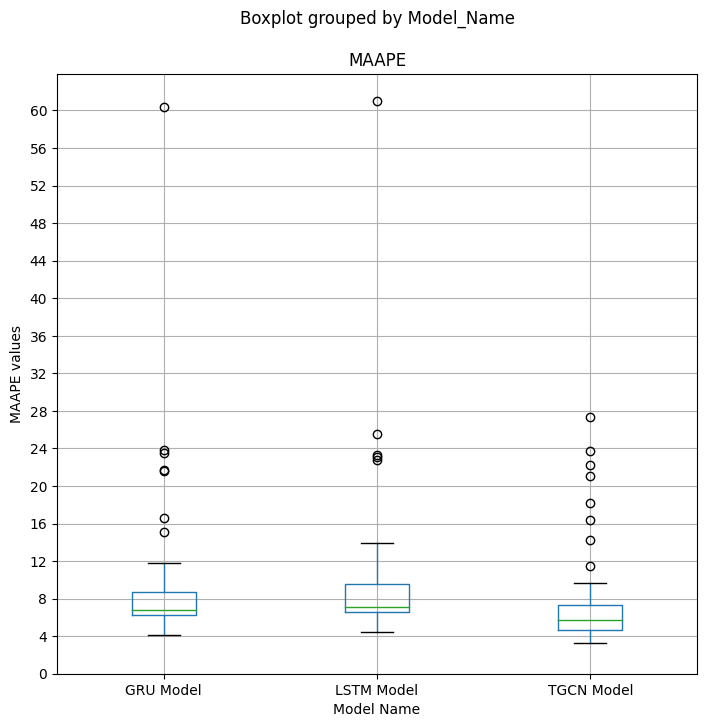

In [83]:
import matplotlib.pyplot as plt

final_resultats = []
diff_resultats = []

######################################################################
# TGCN
######################################################################
# load best model
model_TGCN.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_TGCN}/TGCN_model.pkl".format(input)))

# Make predictions
predictions_TGCN, actuals_TGCN =  test_model(model_TGCN, test_loader_TGCN)


######################################################################
# LSTM
######################################################################
# load best model
model_multivariate_LSTM.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_LSTM_multivariate}/multivariate_LSTM_model.pkl".format(input)))
    
# Make predictions
predictions_LSTM, actuals_LSTM = test_model(model_multivariate_LSTM, 
                                test_loader_LSTM)


######################################################################
# GRU
######################################################################
# Load best model
model_multivariate_GRU.load_state_dict(torch.load(f"{path_save_model}/epoch_{num_epochs_GRU_multivariate}/multivariate_GRU_model.pkl".format(input)))

# Make predictions
predictions_GRU, actuals_GRU = test_model(model_multivariate_GRU, 
                                test_loader_GRU)

for i in range(n_neighbors+1):

######################################################################
# TGCN
######################################################################
    # Save result for each captor
    temp = result_prediction(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
                            actuals_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
    temp.append("TGCN Model")
    temp.append(f"captor {df_PeMS.columns[i]}")
    data = [temp]
    final_resultats.append(temp)

######################################################################
# LSTM
######################################################################
    # Save result
    temp = result_prediction(predictions_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
                            actuals_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])

    temp.append("LSTM Model")
    temp.append(f"captor {df_PeMS.columns[i]}")
    data.append(temp)
    final_resultats.append(temp)


######################################################################
# GRU
######################################################################
    # Save results
    temp = result_prediction(predictions_GRU[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], 
                            actuals_GRU[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"])
    temp.append("GRU Model")
    temp.append(f"captor {df_PeMS.columns[i]}")
    data.append(temp)
    final_resultats.append(temp)


######################################################################
# Dataframe
######################################################################

    df = pd.DataFrame(data, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Model_Name", "Captor"])

    # Définir le mois comme index du DataFrame
    df.set_index(["Captor", 'Model_Name'], inplace=True)

    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', None)

    min_val = df['MAAPE'].min()
    max_val = df['MAAPE'].max()

    df = df.style.apply(highlight_rows, axis=1, min_val=min_val, max_val=max_val)
#     display(df)


# ######################################################################
# # Plots
# ######################################################################

#     plt.figure(figsize=(25, 9))
#     plt.plot(predictions_TGCN[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="orange", label="TGCN pred")
#     plt.plot(actuals_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="black", label="true value")
#     plt.legend(fontsize=15)
#     plt.show()
    
#     plt.figure(figsize=(25, 9))
#     plt.plot(predictions_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="magenta", label="LSTM pred")
#     plt.plot(actuals_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="black", label="true value")
#     plt.legend(fontsize=15)
#     plt.show()
    
#     plt.figure(figsize=(25, 9))
#     plt.plot(predictions_GRU[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="red", label="GRU pred" )
#     plt.plot(actuals_LSTM[:, i] * meanstd_dict[df_PeMS.columns[i]]["std"] + meanstd_dict[df_PeMS.columns[i]]["mean"], color="black", label="true value")
#     plt.legend(fontsize=15)
#     plt.show()


final_resultats = pd.DataFrame(final_resultats, columns=['Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE', "Model_Name", "Captor"])
final_resultats.set_index(["Captor", 'Model_Name'], inplace=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
display(final_resultats.groupby("Model_Name")[["RMSE", "SMAPE", "MAAPE"]].describe())

stats = {
    "TGCN Model" : {"nb_win" : 0},
    "LSTM Model" : {"nb_win" : 0},
    "GRU Model" :  {"nb_win" : 0}
}

for i in final_resultats.index.get_level_values("Captor").unique():
    stats[final_resultats.loc[i]["MAAPE"].idxmin()]["nb_win"] = stats[final_resultats.loc[i]["MAAPE"].idxmin()]["nb_win"] + 1
    diff_resultats.append(["TGCN vs LSTM", round(final_resultats.loc[i].loc["TGCN Model"]["MAAPE"] - final_resultats.loc[i].loc["LSTM Model"]["MAAPE"], 2)])
    diff_resultats.append(["TGCN vs GRU", round(final_resultats.loc[i].loc["TGCN Model"]["MAAPE"] - final_resultats.loc[i].loc["GRU Model"]["MAAPE"], 2)])
    diff_resultats.append(["LSTM vs TGCN", round(final_resultats.loc[i].loc["LSTM Model"]["MAAPE"] - final_resultats.loc[i].loc["TGCN Model"]["MAAPE"], 2)])
    diff_resultats.append(["LSTM vs GRU", round(final_resultats.loc[i].loc["LSTM Model"]["MAAPE"] - final_resultats.loc[i].loc["GRU Model"]["MAAPE"], 2)])
    diff_resultats.append(["GRU vs TGCN", round(final_resultats.loc[i].loc["GRU Model"]["MAAPE"] - final_resultats.loc[i].loc["TGCN Model"]["MAAPE"], 2)])
    diff_resultats.append(["GRU vs LSTM", round(final_resultats.loc[i].loc["GRU Model"]["MAAPE"] - final_resultats.loc[i].loc["LSTM Model"]["MAAPE"], 2)])
diff_resultats = pd.DataFrame(diff_resultats, columns=["Diff", "MAAPE"])
diff_resultats.set_index(["Diff"], inplace=True)
display(diff_resultats.groupby("Diff").describe())

import numpy as np

final_resultats_reset = final_resultats.reset_index()
display(final_resultats_reset.boxplot(column="MAAPE", by="Model_Name", fontsize=10, figsize=(8,8), ylabel="MAAPE values", xlabel="Model Name"))
plt.yticks(np.arange(0, final_resultats_reset["MAAPE"].max(), 4))